1.2 Library Imports
This cell installs all the necessary additional libraries.

In [ ]:
!pip install scikit-learn -q
!pip install wbdata -q

This cell imports all the necessary libraries.

In [5]:
import logging
import warnings
# Suppresses warning errors, there are too many of them there about caches from wbdata
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
import wbdata
import pandas as pd
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from data_handler import Data_Handler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 2. Datasets
## 2.1 Pulling the data
Describe which indicators we chose for each data set 

In [6]:
# Initialise data indicators and relative names for the columns in the data
indicators_gidd = {
    "new_displacement": "New displacement",
    "hazard_type_name": "Hazard type"
}

indicators_hdi = {
    "gnipc": "Gross National Income Per Capita",
    "ineq_inc": "Income Inequality",
    "le": "Life Expectancy at Birth",
    "gii": "Gender Inequality Index",
}

indicators_wb = {
    "EN.POP.DNST": "population_density",
    "SP.DYN.IMRT.IN": "infant_mortality_rate",
    "SL.EMP.TOTL.SP.ZS": "employment_rate",
}
# Get GIDD data
gidd_data = Data_Handler.get_data_GIDD(
    client_id="92DWGXNPOLOM7DR6",
    indicators = indicators_gidd,
    iso3=None,
    start_year=2013,
    end_year=2023,
)
# Get HDI data
hdi_data = Data_Handler.get_data_HDI(
    filepath="HDR25_Composite_indices_complete_time_series.csv",
    indicators=indicators_hdi,
    countries=None,
    start_year=2013,
    end_year=2023
)
# Get WB data
wbdata = Data_Handler.get_data_WB(
    indicators = indicators_wb, 
    countries="all", 
    start_year=2013,
    end_year=2023
 )
wbdata.rename(columns={'ISO3': 'iso3'}, inplace=True)

do we want one column per  year and country or have it per event ??

In [7]:
# Pivot the HDI dataset so that each metric_name becomes a column
hdi_data_pivot = hdi_data.pivot_table(
    index=['iso3', 'year'],   
    columns='metric_name',       
    values='value'               
).reset_index()                  

# Rename columns for consistency
wbdata.rename(columns={'Year': 'year'}, inplace=True)

# Merge datasets on 'iso3' and 'year'
data = (gidd_data
        .merge(hdi_data_pivot, on=['iso3', 'year'], how='outer')
        .merge(wbdata, on=['iso3', 'year'], how='outer')
       )

In [8]:
hdi_iso3 = set(hdi_data_pivot['iso3'].unique())
gidd_iso3 = set(gidd_data['iso3'].unique())

print("ISO3 codes only in HDI:", hdi_iso3 - gidd_iso3)
print("ISO3 codes only in IDMC:", gidd_iso3 - hdi_iso3)

ISO3 codes only in HDI: {'MLT', 'ARM', 'ZZC.MHD', 'QAT', 'MCO', 'ZZH.LAC', 'ZZB.HHD', 'TKM', 'ZZA.VHHD', 'LTU', 'AND', 'EST', 'ZZF.EAP', 'NRU', 'ZZE.AS', 'ZZJ.SSA', 'SGP', 'SMR', 'GNQ', 'MDA', 'ZZI.SA', 'ZZD.LHD', 'ZZG.ECA', 'LIE', 'BHR', 'ZZK.WORLD'}
ISO3 codes only in IDMC: {'IMN', 'PYF', 'GLP', 'COK', 'CYM', 'GRL', 'AIA', 'VIR', 'GUM', 'VGB', 'MAF', 'JEY', 'AB9', 'SXM', 'BMU', 'ASM', 'TCA', 'MNP', 'PRI', 'MTQ', 'XKX', 'GUF', 'REU', 'MAC', 'TWN', 'NCL', 'MYT'}


In [9]:
# Find the intersection of ISO3 codes
hdi_iso3 = set(hdi_data_pivot['iso3'].dropna().unique())
gidd_iso3 = set(gidd_data['iso3'].dropna().unique())

common_iso3 = hdi_iso3 & gidd_iso3  # intersection

# Keep only rows in `data` with ISO3 codes in both datasets and not missing
data = data[data['iso3'].isin(common_iso3) & data['iso3'].notna()]


based on this do we get rid of countries??

## 2.2 Data preprocessing
In this section, we complete all necessary data preprocessing.

We plotted the missing values by year in a bar graph.

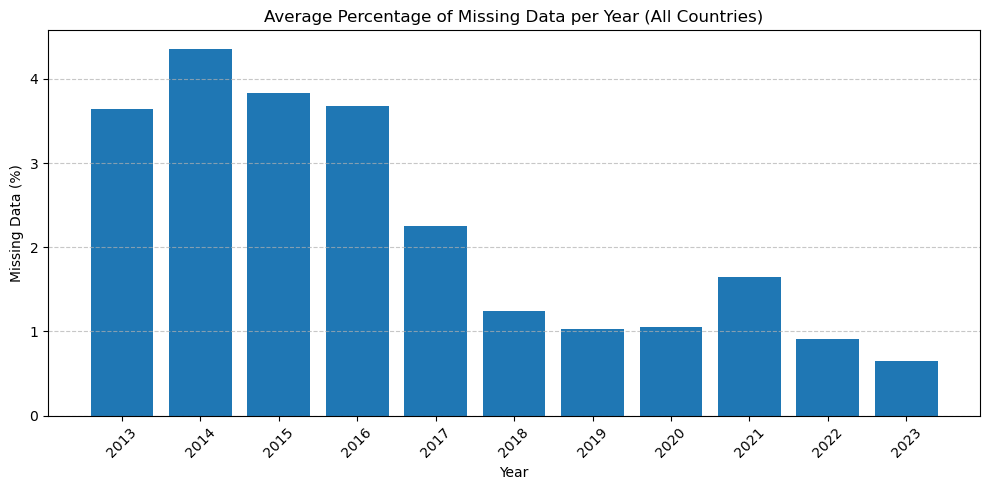

In [10]:
# Exclude trivial columns
cols_to_check = [c for c in data.columns if c not in ['year', 'iso3']]

# Percentage of NaN values per year (average across all countries and columns)
nan_by_year = data.groupby('year')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_by_year.index.astype(str), nan_by_year.values)
plt.title('Average Percentage of Missing Data per Year (All Countries)')
plt.xlabel('Year')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Eliminate  specfic years if needed 

Next, we plot countries and the percentage of missing values per country.

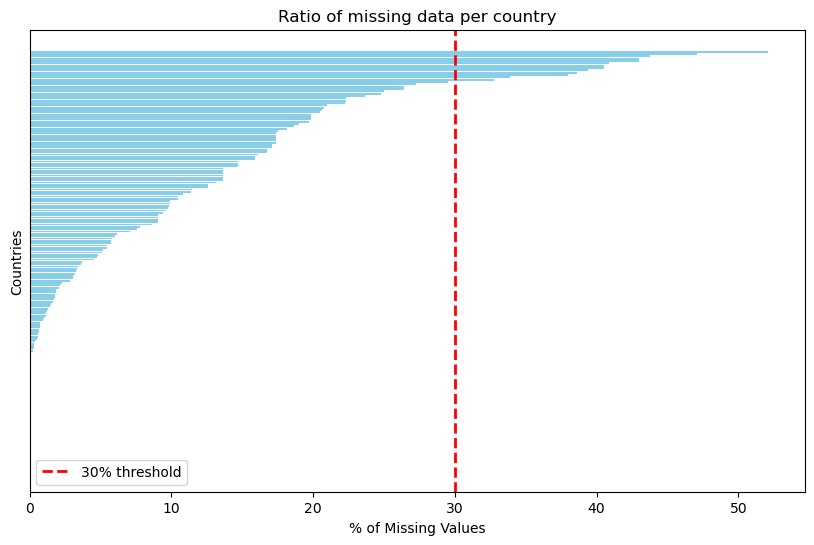

In [11]:
# Get NaN values by country
nan_by_country = data.groupby('iso3')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)
nan_by_country = nan_by_country.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,6))
plt.barh(range(len(nan_by_country)), nan_by_country.values, color='skyblue')  # use range for no labels
plt.axvline(x=30, color='red', linestyle='--', linewidth=2, label='30% threshold')  # red line at 30%
plt.xlabel('% of Missing Values')
plt.ylabel("Countries")
plt.title('Ratio of missing data per country')
plt.yticks([])  # remove y-axis labels
plt.legend()
plt.gca().invert_yaxis()  # largest on top
plt.show()


From the graph, we can see that a lot of the countries have a majority of their data missing. We have decided to exclude countries that have more than 70 per cent data missing, which is indicated by the red line in the graph.
Eliminate countries if needed 

Now, we want to inspect the trends of missing data between different factors in our dataset.

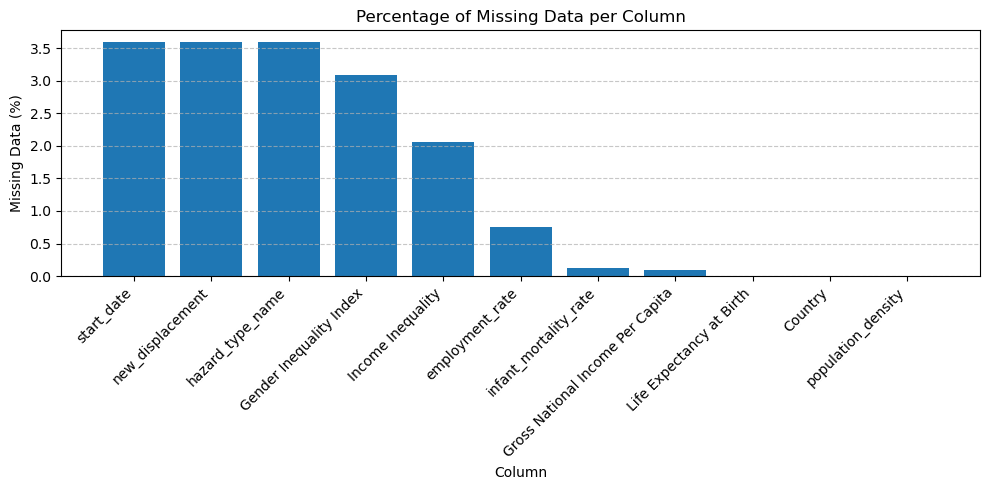


Missing data percentage per column (sorted):
start_date                          3.593240
new_displacement                    3.593240
hazard_type_name                    3.593240
Gender Inequality Index             3.089238
Income Inequality                   2.051586
employment_rate                     0.758968
infant_mortality_rate               0.118589
Gross National Income Per Capita    0.088942
Life Expectancy at Birth            0.000000
Country                             0.000000
population_density                  0.000000
dtype: float64


In [14]:
# Get NaN values per column
nan_per_column = data[cols_to_check].isna().mean() * 100
nan_per_column_sorted = nan_per_column.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_per_column_sorted.index, nan_per_column_sorted.values)
plt.title(f'Percentage of Missing Data per Column')
plt.xlabel('Column')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nMissing data percentage per column (sorted):")
print(nan_per_column_sorted)

Eliminate factor if needed

## 2.3 Uniformize data
Next, we look at the minimum and maximum values each column can obtain. All factors except for GII are measured from 0 to 100. We have decided to multiply the GII by a factor of 100, as this will later help us visualise the results.

In [ ]:
# Print min and max values of each column
min_max = data.agg(['min', 'max']).transpose().reset_index()
min_max.columns = ['Column', 'Min', 'Max']
print(min_max)

# Multiply GII by a 100
data['GII'] = data['GII'] * 100

## 2.4 Missing values
We examine the number of missing values in the dataset to determine an appropriate strategy for handling them. Addressing missing data is essential because it can bias results, reduce the reliability of our analyses, and hinder modeling performance. Many machine learning algorithms cannot process missing values directly and require complete input data. Therefore, understanding the extent and pattern of missingness ensures that subsequent analyses and models are both accurate and valid.

In [ ]:
# Inspect the remaining nan values
data.isna().sum()